In [23]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


In [24]:
def init(N):
    return np.random.choice([-1, 1], N)


def gen_neigh(L):
    N = L**2

    neigh = np.empty((N, 4), dtype=np.int16)

    for i in range(N):
        if i % L == L - 1:  # dir
            right = i - L + 1
        else:
            right = i + 1

        neigh[i][0] = right

        if i >= (L**2) - L:  # cima
            up = i - N + L
        else:
            up = i + L

        neigh[i][1] = up

        if i % L == 0:  # esq
            left = i + L - 1
        else:
            left = i - 1

        neigh[i][2] = left

        if i < L:  # baixo
            down = i + N - L
        else:
            down = i - L

        neigh[i][3] = down

    return neigh


def rand_site(N):
    return np.random.choice(range(N))


def calc_energy(spins, neigh):
    sum = 0

    for i in spins:
        neigh_i = neigh[i][0:2]

        for j in neigh_i:
            sum += spins[i] * spins[j]

    return -sum


# energy difference when i is flipped
def en_diff(i, energy, spins, neigh):
    sum = 0

    for j in neigh[i]:
        sum += spins[j]

    delta = 2 * spins[i] * sum

    return delta


def get_expos(T):
    expos = {
        -8: np.exp(8 / T),
        -4: np.exp(4 / T),
        0: 1,
        4: np.exp(-4 / T),
        8: np.exp(-8 / T),
    }
    return expos


def mc_step(spins, energy, neigh):
    i = rand_site(N)
    de = en_diff(i, energy, spins, neigh)
    P = expos[de]
    r = np.random.rand()

    if r <= P:
        spins[i] = -spins[i]
        energy += de

    return spins, energy


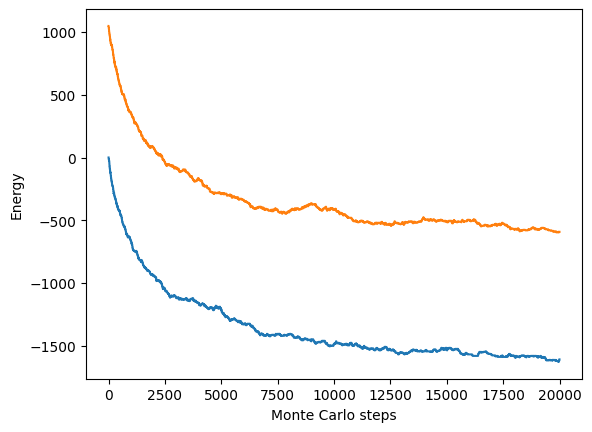

In [25]:
L = 32
N = L**2
T = 1.5
neigh = gen_neigh(L)
expos = get_expos(T)

fig, ax = plt.subplots()
ax.set_xlabel("Monte Carlo steps")
ax.set_ylabel("Energy")

for i in range(2):
    spins = init(N)
    energy = calc_energy(spins, neigh)

    energies = []

    for _ in range(20000):
        spins, energy = mc_step(spins, energy, neigh)

        energies.append(energy)

    ax.plot(energies)
